# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')


In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))


(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)],np.random.randint(vectors.shape[1], size=10))

[(79, 'able'), (236, 'code'), (230, 'cleveland'), (655, 'ohio'), (41, '33'), (995, 'year'), (267, 'corporation'), (165, 'blood'), (154, 'berkeley'), (264, 'controller')] [391 569 193 749 799 465 475  63 419 973]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words Your code here
print(words[:10])


Nb mots= 3252437
['From:', 'lerxst@wam.umd.edu', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?']


In [7]:
from collections import Counter
# Use Counter to count word occurrences
word_counts = Counter(words)

# Get the most common words and their frequencies
most_common_words = word_counts.most_common(10)  # Adjust the number as needed

# Print the results
for word, frequency in most_common_words:
    print(f'{word}: {frequency} times')

the: 127670 times
to: 69836 times
of: 66705 times
a: 56148 times
and: 52580 times
is: 39554 times
in: 37787 times
I: 37616 times
that: 34582 times
>: 27843 times


### Plot the N frequent words and verify that its follows a Zipf law

[('the', 127670), ('to', 69836), ('of', 66705), ('a', 56148), ('and', 52580), ('is', 39554), ('in', 37787), ('I', 37616), ('that', 34582), ('>', 27843)]


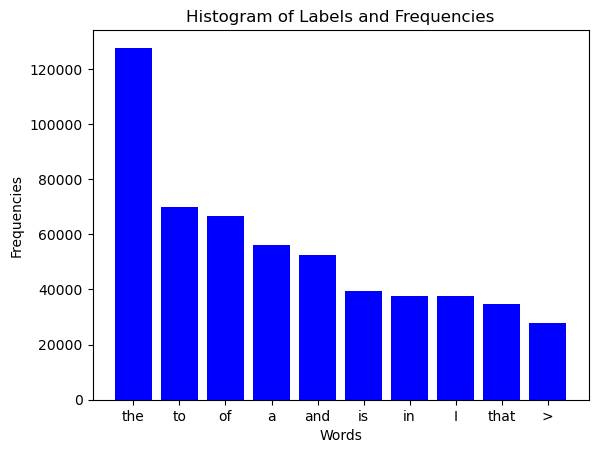

In [8]:
N=10
Words=[]
Frequency=[]
most_common_words=word_counts.most_common(N)
print(most_common_words[:10])
for word, frequency in most_common_words:
    Words.append(word)
    Frequency.append(frequency)

import matplotlib.pyplot as plt

labels = Words
frequencies = Frequency

# Plotting the histogram
plt.bar(labels, frequencies, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Histogram of Labels and Frequencies')
plt.show()


### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

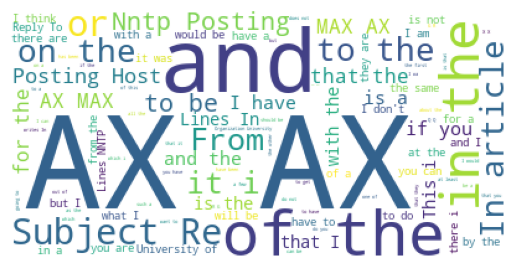

In [9]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

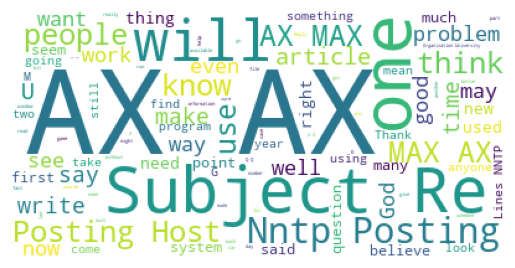

In [10]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

(-0.5, 399.5, 199.5, -0.5)

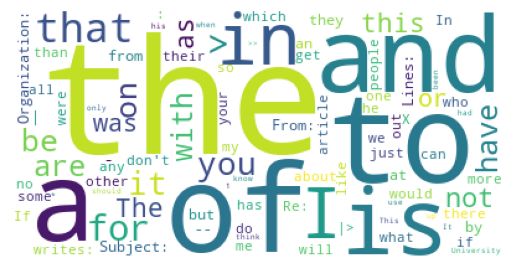

In [11]:
wordcloud = WordCloud(
    background_color='white',
    stopwords = STOPWORDS,
    max_words=100).generate_from_frequencies(frequencies=word_counts)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


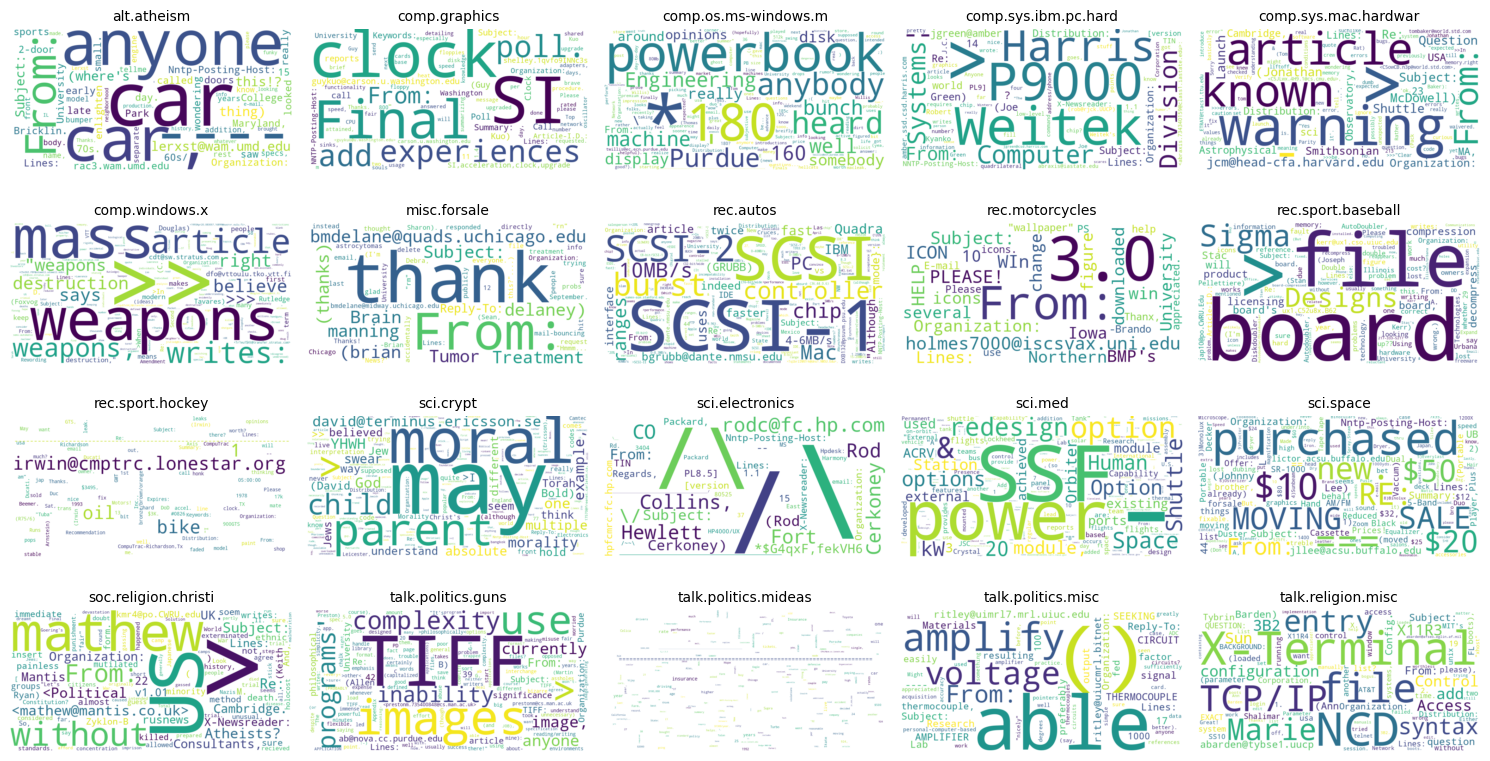

In [20]:
# Your code here
from collections import defaultdict
import math

class_names = newsgroups_train.target_names
class_labels = np.unique(newsgroups_train.target)

class_docs = defaultdict(list)
for doc, label in zip(data, class_labels):
    class_docs[class_names[label]].append(doc)


num_classes = len(class_docs)

stopwords = STOPWORDS

num_classes = len(class_docs)

grid_size = math.ceil(math.sqrt(num_classes))

plt.figure(figsize=(15, 10))

for i, (class_name, docs) in enumerate(class_docs.items(), 1):
    corpus = " ".join(docs)
    words = corpus.split()
    
    word_counts = Counter(word for word in words if word.lower() not in stopwords)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate_from_frequencies(word_counts)
    
    ax = plt.subplot(grid_size, grid_size, i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{class_name[:20]}', fontsize=10)  # Shorten the title if it's too long
    ax.axis("off")

plt.tight_layout()
plt.show()


# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [17]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

c:\Users\hatem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[2.64200772e-03, 1.72556979e-03, 1.10330745e-03, ...,
        5.70528778e-03, 2.72938417e-03, 2.51514002e-03],
       [3.61169636e-03, 2.67107525e-03, 6.67928714e-04, ...,
        6.99879179e-03, 2.44666453e-03, 3.15483514e-03],
       [3.23407676e-03, 2.17253305e-03, 1.94828380e-03, ...,
        4.44554390e-03, 4.06729375e-03, 8.75936802e-04],
       ...,
       [3.25722139e-03, 1.12336419e-02, 1.51121114e-03, ...,
        1.24136961e-02, 5.32988561e-03, 7.42519147e-03],
       [2.16881195e-03, 2.78943545e-02, 3.96979682e-04, ...,
        7.28880416e-03, 1.25270533e-02, 5.51950356e-03],
       [3.82974480e-03, 2.71791298e-03, 2.51429870e-03, ...,
        5.28086807e-03, 1.83526233e-03, 5.76348639e-05]])

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

1) Qualitative

Cluster 0: ['posting', 'utexas', 'computer', 'article', 'writes', 'science', 'university', 'dept', 'edu', 'cs']
Cluster 1: ['cleveland', 'washington', 'writes', 'cwru', 'article', 'university', 'posting', 'nntp', 'host', 'edu']
Cluster 2: ['host', 'com', 'edu', 'posting', 'article', 'writes', 'university', 'bnr', 'canada', 'ca']
Cluster 3: ['use', 'ms', 'com', 'program', 'edu', 'files', 'dos', 'file', 'window', 'windows']
Cluster 4: ['posting', 'host', 'com', 'writes', 'article', 'university', 'edu', 'acs', 'state', 'ohio']
Cluster 5: ['monitor', 'controller', 'ide', 'video', 'apple', 'mac', 'edu', 'scsi', 'card', 'drive']
Cluster 6: ['sun', 'host', 'nntp', 'edu', 'posting', 'netcom', 'hp', 'writes', 'article', 'com']
Cluster 7: ['article', 'writes', 'gary', 'purdue', 'university', 'buffalo', 'utexas', 'columbia', 'edu', 'cc']
Cluster 8: ['___', 'laboratory', 'writes', 'article', 'edu', 'center', 'research', 'space', 'gov', 'nasa']
Cluster 9: ['ed', 'nntp', 'edu', 'article', 'posting',

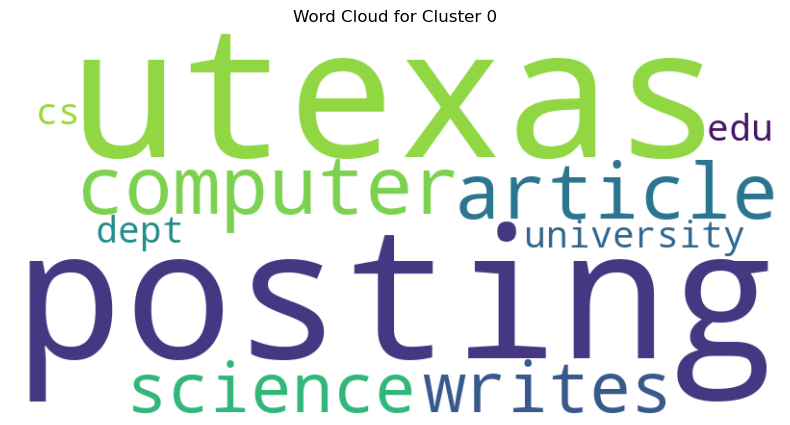

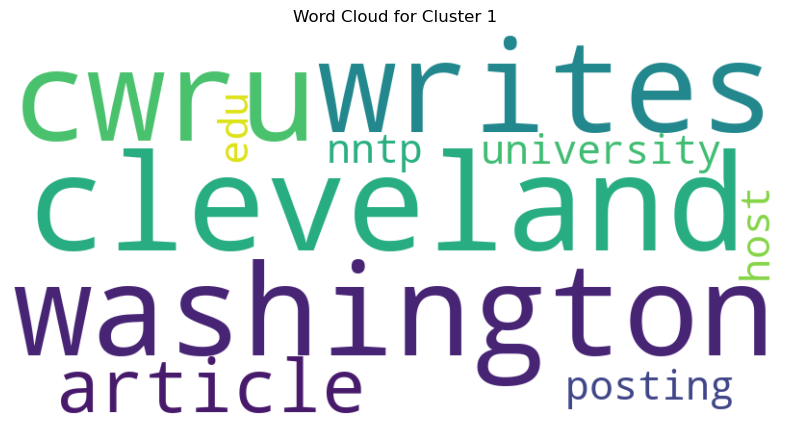

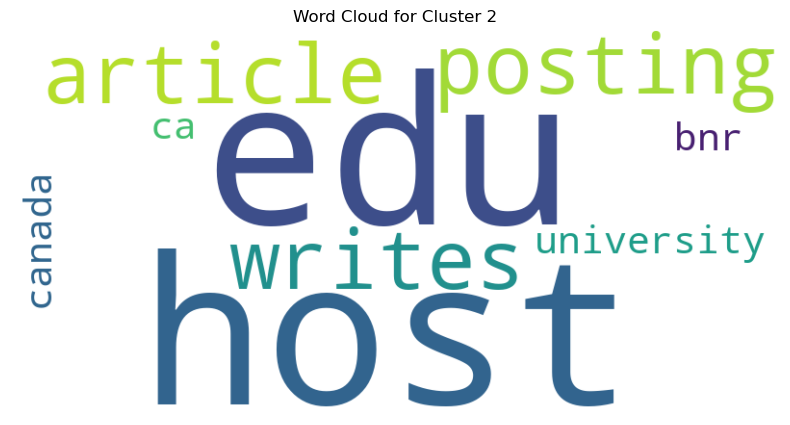

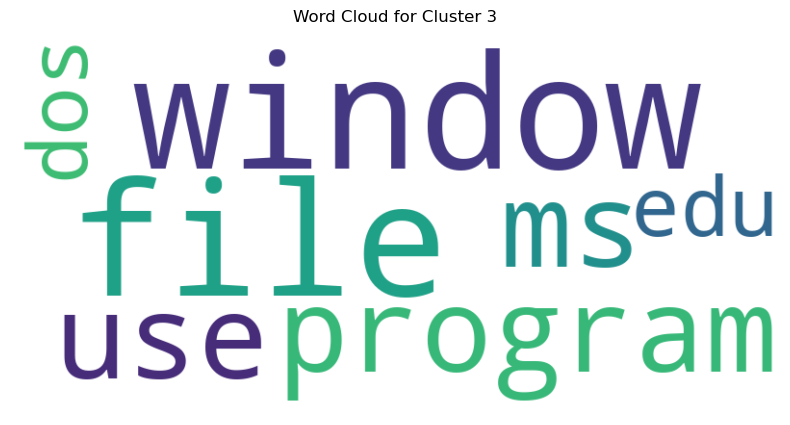

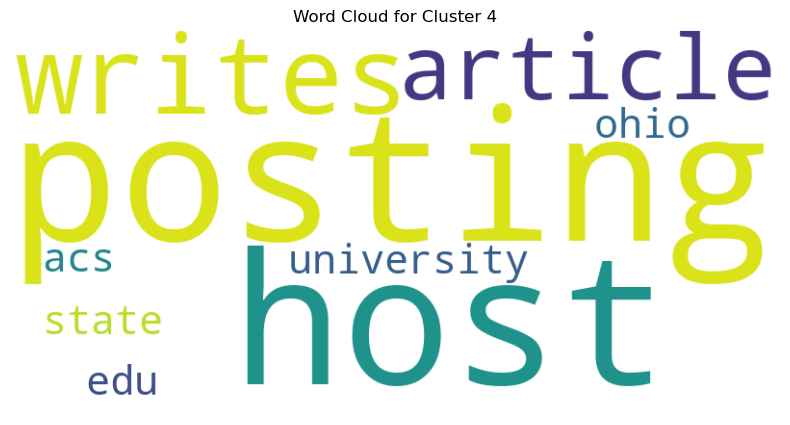

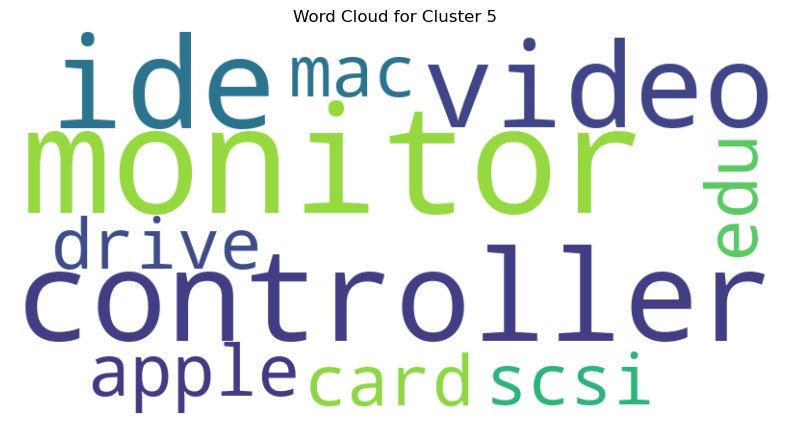

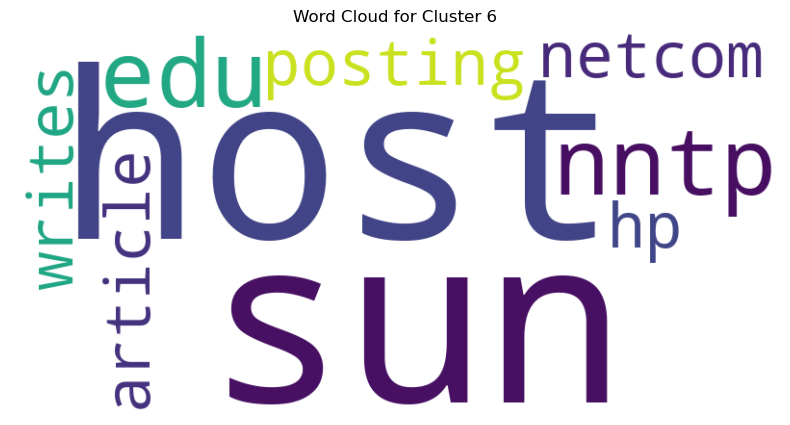

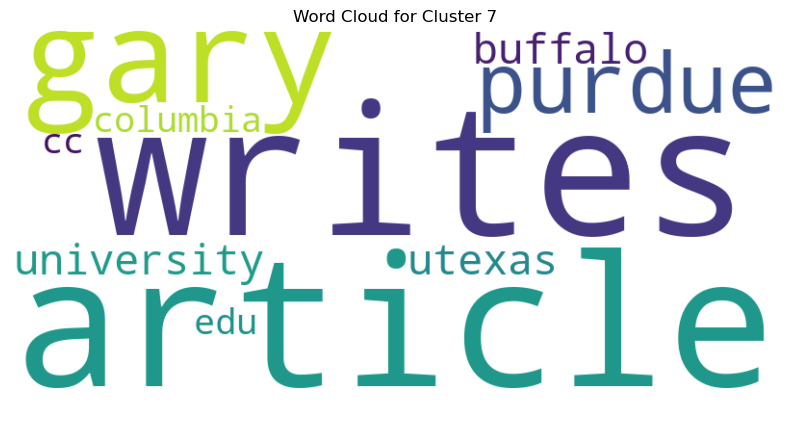

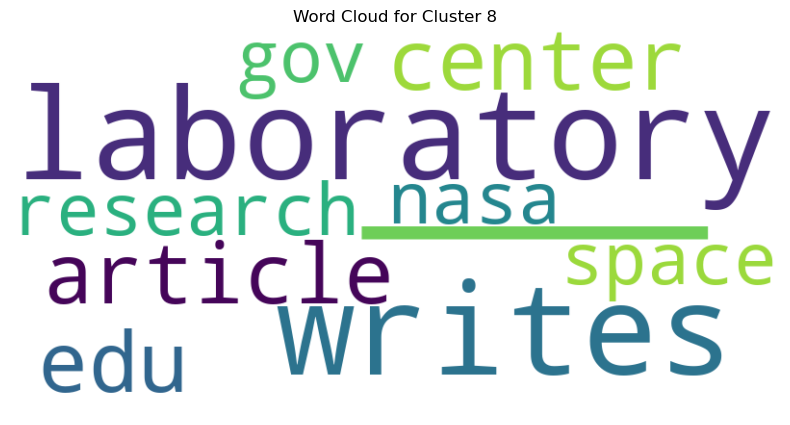

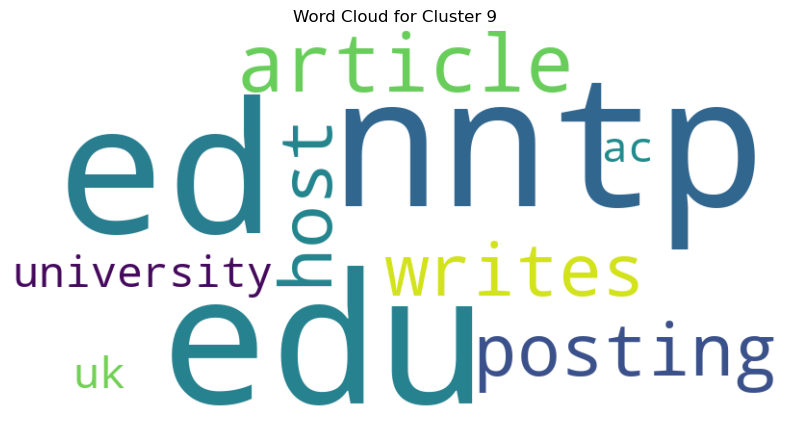

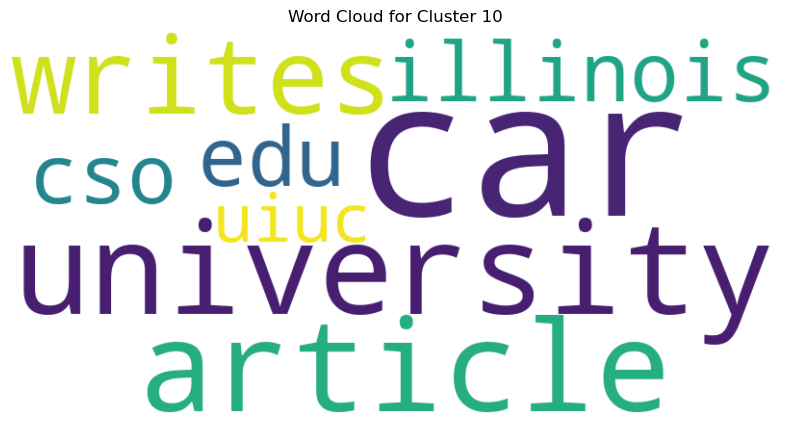

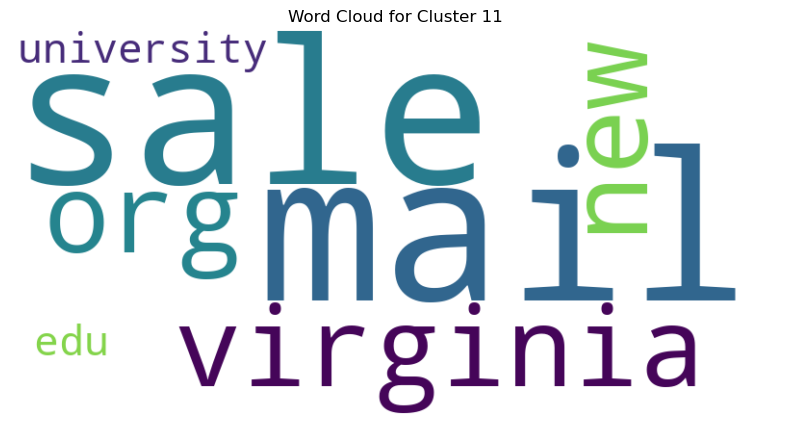

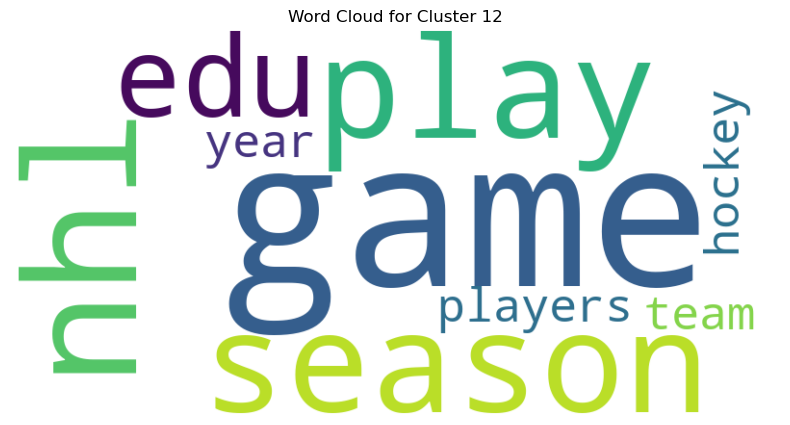

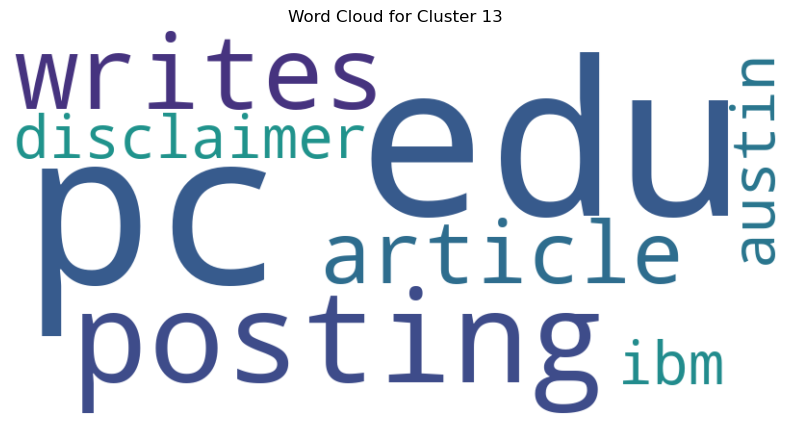

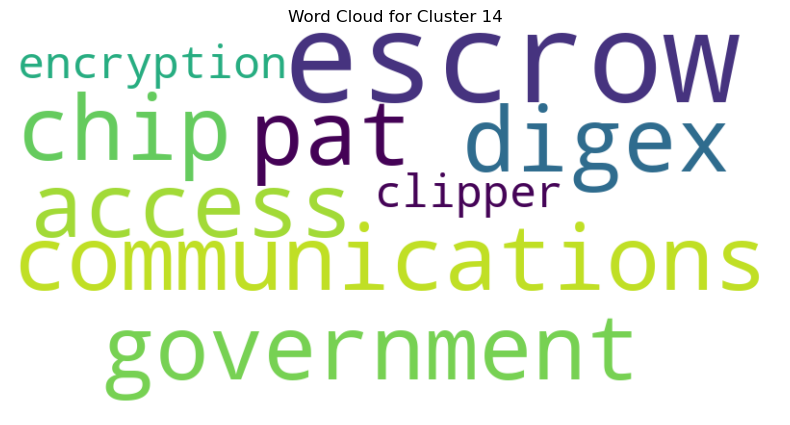

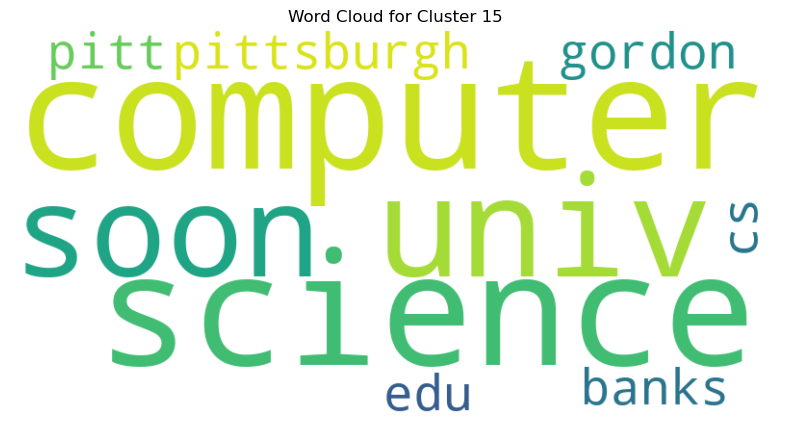

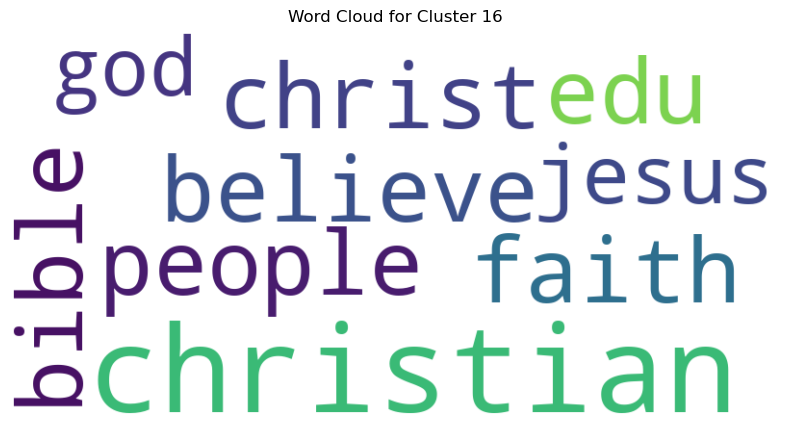

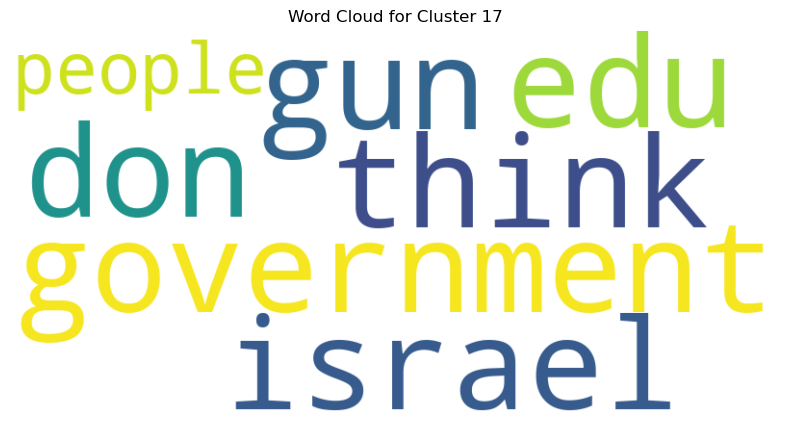

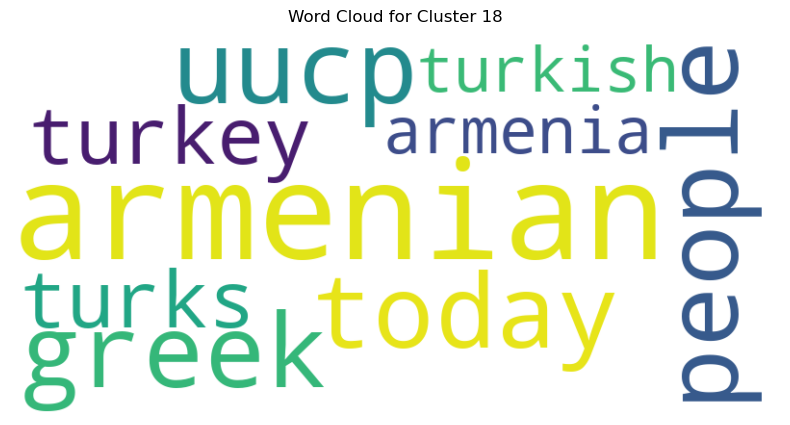

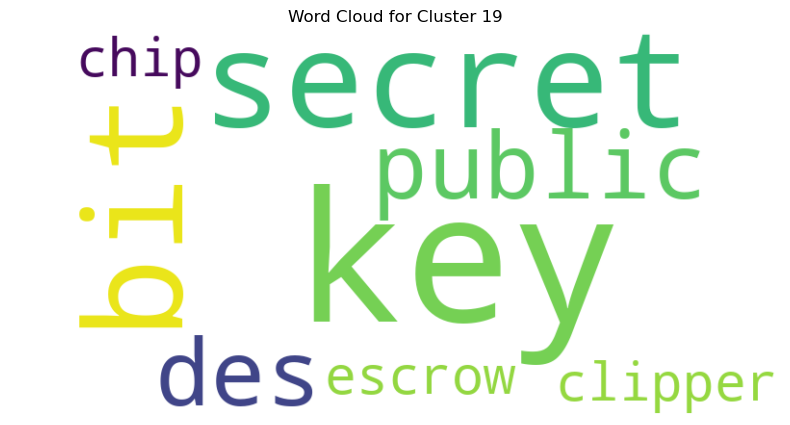

In [21]:
# Find the top 10 words for each cluster
top_n = 10
cluster_terms = {}
feature_names = vectorizer.get_feature_names_out()
for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    important_indices = centroid.argsort()[-top_n:]
    terms = [feature_names[index] for index in important_indices]
    cluster_terms[i] = terms
    print(f"Cluster {i}: {terms}")

for cluster_num, words in cluster_terms.items():
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(" ".join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.axis('off')
    plt.show()

2) Quantitative

In [22]:
import numpy as np
from sklearn.metrics import rand_score, adjusted_rand_score

labels = newsgroups_train.target
cluster_labels = kmeans.labels_

purity_sum = 0
for i in range(kmeans.n_clusters):
    indices = np.where(cluster_labels == i)[0]
    cluster_true_labels = labels[indices]
    most_common_label, count = Counter(cluster_true_labels).most_common(1)[0]
    purity = count / len(cluster_true_labels)
    purity_sum += purity
    print(f"Cluster {i}, Purity: {purity}")

overall_purity = purity_sum / kmeans.n_clusters
print(f"Overall Purity: {overall_purity}")

r_score = rand_score(labels, cluster_labels)
adj_r_score = adjusted_rand_score(labels, cluster_labels)
print(f'Rand Score: {r_score}')
print(f'Adjusted Rand Score: {adj_r_score}')


Cluster 0, Purity: 0.1210762331838565
Cluster 1, Purity: 0.10322108345534407
Cluster 2, Purity: 0.164969450101833
Cluster 3, Purity: 0.5123674911660777
Cluster 4, Purity: 0.2558139534883721
Cluster 5, Purity: 0.3721590909090909
Cluster 6, Purity: 0.13713862120088954
Cluster 7, Purity: 0.11784511784511785
Cluster 8, Purity: 0.4770992366412214
Cluster 9, Purity: 0.15339233038348082
Cluster 10, Purity: 0.5159574468085106
Cluster 11, Purity: 0.11822916666666666
Cluster 12, Purity: 0.62
Cluster 13, Purity: 0.16541353383458646
Cluster 14, Purity: 0.6792452830188679
Cluster 15, Purity: 0.9787234042553191
Cluster 16, Purity: 0.6098901098901099
Cluster 17, Purity: 0.22819885900570497
Cluster 18, Purity: 1.0
Cluster 19, Purity: 0.884393063583815
Overall Purity: 0.41075667377194325
Rand Score: 0.8831787877931313
Adjusted Rand Score: 0.09727062319040214


# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [18]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

NameError: name 'U' is not defined

In [ ]:
NN2cluster = np.argmax(np.abs(vectors_SVDn), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [ ]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



## LDA-viz

In [ ]:
# pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**